In [53]:
# Imports
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd
import time
from sklearn.metrics import pairwise_distances
from kpt import kernel_two_sample_test_reweight
from dr_kpt import xMMD2dr, xMMD2dr_cross_fit
from warfarin import make_scenario, generate_ope_data, find_best_params
import os
from tqdm import tqdm


In [59]:
scenario_id = 'III'
seed =3
X, T, Y, pi, pi_prime = make_scenario(scenario_id, seed=seed)
data = generate_ope_data(X, T, Y, pi, pi_prime)

Y = data["Y"].reshape(-1, 1)
T = data["T"]
w_pi = data["w_pi"]
w_pi_prime = data["w_pi_prime"]
pi_samples = data["pi_samples"]
pi_prime_samples = data["pi_prime_samples"]

reg_lambda = find_best_params(X, T, Y)
try:
    sigma2 = np.median(pairwise_distances(Y, Y)) ** 2
    gamma_k = 1.0 / sigma2
except:
    gamma_k = None
                    
stat = xMMD2dr_cross_fit(
    Y, X, T, w_pi, w_pi_prime,
    pi_samples, pi_prime_samples,
    kernel_function="rbf", reg_lambda=1e2, gamma=gamma_k,
)
pval = 1 - st.norm.cdf(stat)

In [60]:
pval

0.007238023414121053

In [50]:
stat, _, pval = kernel_two_sample_test_reweight(
    Y, w_pi, w_pi_prime,
    kernel_function="rbf",
    gamma=gamma_k,
    iterations=1000,
    random_state=seed
)

In [51]:
pval

0.975

In [61]:
def run_ope_tests(scenario_list, method_list, num_experiments, iterations, name_folder):

    os.makedirs(name_folder, exist_ok=True)

        
    for scenario_id in scenario_list:
        print(f"Scenario {scenario_id}")
        for method in method_list:
            p_values = np.zeros(num_experiments)
            stats = np.zeros(num_experiments)
            times = np.zeros(num_experiments)

            for seed in tqdm(range(num_experiments)):
                # === Data generation ===
                X, T, Y, pi, pi_prime = make_scenario(scenario_id, seed=seed)
                # X = X[:ns]
                data = generate_ope_data(X, T, Y, pi, pi_prime)

                Y = data["Y"].reshape(-1, 1)
                T = data["T"]
                w_pi = data["w_pi"]
                w_pi_prime = data["w_pi_prime"]
                pi_samples = data["pi_samples"]
                pi_prime_samples = data["pi_prime_samples"]

                
                try:
                    sigma2 = np.median(pairwise_distances(Y, Y)) ** 2
                    gamma_k = 1.0 / sigma2
                except:
                    gamma_k = None

                try:
                    t0 = time.time()
                    if method == "PE-linear":
                        stat, _, pval = kernel_two_sample_test_reweight(
                            Y, w_pi, w_pi_prime,
                            kernel_function="linear",
                            iterations=iterations,
                            random_state=seed
                        )
                    elif method == "KPE":
                        stat, _, pval = kernel_two_sample_test_reweight(
                            Y, w_pi, w_pi_prime,
                            kernel_function="rbf",
                            gamma=gamma_k,
                            iterations=iterations,
                            random_state=seed
                        )
                    elif method == "DR-CF":
                        stat = xMMD2dr_cross_fit(
                            Y, X, T, w_pi, w_pi_prime,
                            pi_samples, pi_prime_samples,
                            kernel_function="rbf", reg_lambda=1e2
                        )
                        pval = 1 - st.norm.cdf(stat)
                    else:
                        raise ValueError(f"Unknown method: {method}")
                    elapsed = time.time() - t0
                except Exception as e:
                    stat, pval, elapsed = np.nan, np.nan, 0.0

                p_values[seed] = pval
                stats[seed] = stat
                times[seed] = elapsed

            df = pd.DataFrame({
                "p_value": p_values,
                "stat": stats,
                "time": times
            })
            fname = f"{name_folder}/scenario{scenario_id}_{method}.csv"
            df.to_csv(fname, index=False)
            print(f"Saved: {fname}")



In [62]:
num_experiments = 10
iterations = 1000
scenario_list = ["I", 'II', 'III', 'IV']
method_list = ['DR-CF']
name_folder = "results" 

run_ope_tests(
    scenario_list=scenario_list,
    method_list=method_list,
    num_experiments=num_experiments,
    iterations=iterations,
    name_folder=name_folder,
)

Scenario I


100%|██████████| 10/10 [10:32<00:00, 63.27s/it]


Saved: results/scenarioI_DR-CF.csv
Scenario II


100%|██████████| 10/10 [10:31<00:00, 63.18s/it]


Saved: results/scenarioII_DR-CF.csv
Scenario III


100%|██████████| 10/10 [10:29<00:00, 62.99s/it]


Saved: results/scenarioIII_DR-CF.csv
Scenario IV


100%|██████████| 10/10 [10:37<00:00, 63.71s/it]

Saved: results/scenarioIV_DR-CF.csv


In [5]:
num_experiments = 100
iterations = 100
sample_size_list = np.arange(100, 450, 50)
scenario_list = ['II', 'III', 'IV']
method_list = ["DR-CF"]
name_folder = "results" 

run_ope_tests(
    scenario_list=scenario_list,
    method_list=method_list,
    sample_size_list=sample_size_list,
    num_experiments=num_experiments,
    iterations=iterations,
    name_folder=name_folder,
)

Scenario II
Saved: results/ns100_scenarioII_DR-CF.csv
Saved: results/ns150_scenarioII_DR-CF.csv
Saved: results/ns200_scenarioII_DR-CF.csv
Saved: results/ns250_scenarioII_DR-CF.csv
Saved: results/ns300_scenarioII_DR-CF.csv
Saved: results/ns350_scenarioII_DR-CF.csv
Saved: results/ns400_scenarioII_DR-CF.csv
Scenario III
Saved: results/ns100_scenarioIII_DR-CF.csv
Saved: results/ns150_scenarioIII_DR-CF.csv
Saved: results/ns200_scenarioIII_DR-CF.csv
Saved: results/ns250_scenarioIII_DR-CF.csv
Saved: results/ns300_scenarioIII_DR-CF.csv
Saved: results/ns350_scenarioIII_DR-CF.csv
Saved: results/ns400_scenarioIII_DR-CF.csv
Scenario IV
Saved: results/ns100_scenarioIV_DR-CF.csv
Saved: results/ns150_scenarioIV_DR-CF.csv
Saved: results/ns200_scenarioIV_DR-CF.csv
Saved: results/ns250_scenarioIV_DR-CF.csv
Saved: results/ns300_scenarioIV_DR-CF.csv
Saved: results/ns350_scenarioIV_DR-CF.csv
Saved: results/ns400_scenarioIV_DR-CF.csv


In [17]:
num_experiments = 100
iterations = 10000
sample_size_list = np.arange(100, 450, 50)
scenario_list = ['I', "II", 'III', "IV"]
method_list = ["PE-linear", "KPE"]
name_folder = "results" 

run_ope_tests(
    scenario_list=scenario_list,
    method_list=method_list,
    sample_size_list=sample_size_list,
    num_experiments=num_experiments,
    iterations=iterations,
    name_folder=name_folder,
)

Scenario III
Saved: results/ns100_scenarioIII_PE-linear.csv
Saved: results/ns150_scenarioIII_PE-linear.csv
Saved: results/ns200_scenarioIII_PE-linear.csv
Saved: results/ns250_scenarioIII_PE-linear.csv
Saved: results/ns300_scenarioIII_PE-linear.csv
Saved: results/ns350_scenarioIII_PE-linear.csv
Saved: results/ns400_scenarioIII_PE-linear.csv
Saved: results/ns100_scenarioIII_KPE.csv
Saved: results/ns150_scenarioIII_KPE.csv
Saved: results/ns200_scenarioIII_KPE.csv
Saved: results/ns250_scenarioIII_KPE.csv
Saved: results/ns300_scenarioIII_KPE.csv
Saved: results/ns350_scenarioIII_KPE.csv
Saved: results/ns400_scenarioIII_KPE.csv
Scenario IV
Saved: results/ns100_scenarioIV_PE-linear.csv
Saved: results/ns150_scenarioIV_PE-linear.csv
Saved: results/ns200_scenarioIV_PE-linear.csv
Saved: results/ns250_scenarioIV_PE-linear.csv
Saved: results/ns300_scenarioIV_PE-linear.csv
Saved: results/ns350_scenarioIV_PE-linear.csv
Saved: results/ns400_scenarioIV_PE-linear.csv
Saved: results/ns100_scenarioIV_KPE.c

In [7]:
import numpy as np
import pandas as pd
import os

# === Scenario I (null)
scenario_list_null = ['I']
ns_list_null = np.arange(100, 1050, 50)
methods_null = ['DR-CF', 'DR']

# === Scenarios II–IV (non-null)
scenario_list_alt = ['II', 'III', 'IV']
ns_list_alt = np.arange(100, 450, 50)
methods_alt = ["PE-linear", 'KPE', 'DR-CF']

# === Common folder
results_folder = 'results/'

# === Load all files into dictionary
d_results = dict()

# Null case (Scenario I)
for scenario in scenario_list_null:
    for method in methods_null:
        for ns in ns_list_null:
            fname = f"{results_folder}ns{ns}_scenario{scenario}_{method}.csv"
            if os.path.exists(fname):
                d_results[fname] = pd.read_csv(fname)
            else:
                print(f"Missing file: {fname}")

# Alternative cases (Scenarios II–IV)
for scenario in scenario_list_alt:
    for method in methods_alt:
        for ns in ns_list_alt:
            fname = f"{results_folder}ns{ns}_scenario{scenario}_{method}.csv"
            if os.path.exists(fname):
                d_results[fname] = pd.read_csv(fname)
            else:
                print(f"Missing file: {fname}")


Missing file: results/ns300_scenarioIII_PE-linear.csv
Missing file: results/ns350_scenarioIII_PE-linear.csv
Missing file: results/ns400_scenarioIII_PE-linear.csv
Missing file: results/ns100_scenarioIII_KPE.csv
Missing file: results/ns150_scenarioIII_KPE.csv
Missing file: results/ns200_scenarioIII_KPE.csv
Missing file: results/ns250_scenarioIII_KPE.csv
Missing file: results/ns300_scenarioIII_KPE.csv
Missing file: results/ns350_scenarioIII_KPE.csv
Missing file: results/ns400_scenarioIII_KPE.csv
Missing file: results/ns100_scenarioIV_PE-linear.csv
Missing file: results/ns150_scenarioIV_PE-linear.csv
Missing file: results/ns200_scenarioIV_PE-linear.csv
Missing file: results/ns250_scenarioIV_PE-linear.csv
Missing file: results/ns300_scenarioIV_PE-linear.csv
Missing file: results/ns350_scenarioIV_PE-linear.csv
Missing file: results/ns400_scenarioIV_PE-linear.csv
Missing file: results/ns100_scenarioIV_KPE.csv
Missing file: results/ns150_scenarioIV_KPE.csv
Missing file: results/ns200_scenarioI

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, gaussian_kde
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, gaussian_kde
import os

def plot_null_diagnostics_observational(
    d,
    scenario="I",
    method="DR",
    ns=350,
    name_folder="results/",
    ns_list=np.arange(100, 400, 50),
    confidence_level=0.01,
    save_path="plots/null_scenarioI_errorbar.png",
):
    # === Plot styling ===
    plt.rcParams["figure.figsize"] = (18, 5)
    plt.rcParams["axes.grid"] = True
    plt.rc("axes", labelsize=13)
    plt.rc("xtick", labelsize=11)
    plt.rc("ytick", labelsize=11)

    # Colorblind-safe colors
    cb_colors = {
        "hist": "#0072B2",     # blue
        "pdf": "#E69F00",      # orange
        "kde": "#999999",      # grey
        "qq": "#0D3B66",       # navy
        "errorbar": "#56B4E9", # light blue
        "nominal": "#4D4D4D"   # dark grey
    }

    method_dict = {"DR": "DR", "DR-CF": "DR-KPT"}
    m_dict = {0: "^", 1: "s", 2: "v", 3: "o", 4: "D"}

    # === (A) Histogram + KDE + Normal PDF ===
    fname = f"{name_folder}ns{ns}_scenario{scenario}_{method}.csv"
    stat_values = d[fname]["stat"]
    x_axis = np.linspace(-3, 3, 500)

    plt.subplot(1, 3, 1)
    plt.hist(stat_values, bins=25, density=True, color=cb_colors["hist"], alpha=0.5,
             label=f"Draws from {method_dict[method]}", edgecolor='black')
    kde = gaussian_kde(stat_values)
    plt.plot(x_axis, kde(x_axis), color=cb_colors["kde"], linestyle="--", label="KDE")
    plt.plot(x_axis, norm.pdf(x_axis), color=cb_colors["pdf"], linewidth=2, label="Standard normal pdf")
    plt.xlabel(method_dict[method])
    plt.ylabel("Density")
    plt.title("(A)")
    plt.legend(loc="upper left")

    # === (B) QQ-plot ===
    plt.subplot(1, 3, 2)
    osm, osr = probplot(stat_values, dist="norm")[0]
    plt.plot(osm, osr, marker='o', linestyle='', color=cb_colors["qq"], markersize=3)
    plt.plot(osm, osm, color="black", linestyle="--")
    plt.title("(B)")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")

    # === (C) False positive rate with error bars ===
    plt.subplot(1, 3, 3)
    rejection_proportion = np.zeros(len(ns_list))
    for j, ns_val in enumerate(ns_list):
        fname = f"{name_folder}ns{ns_val}_scenario{scenario}_{method}.csv"
        pvals = d[fname]["p_value"]
        rejection_proportion[j] = (pvals < confidence_level).mean()

    varhat = rejection_proportion * (1 - rejection_proportion) / len(pvals)
    plt.errorbar(
        x=ns_list,
        y=rejection_proportion,
        yerr=1.96 * np.sqrt(varhat),
        capsize=4,
        marker=m_dict[0],
        markersize=8,
        color=cb_colors["errorbar"],
        linestyle='--',
        label=method_dict[method]
    )
    plt.axhline(confidence_level, color=cb_colors["nominal"], linestyle="--", label="Nominal level")
    plt.title("(C)")
    plt.xlabel("Sample size")
    plt.ylabel("False positive rate")
    # plt.ylim((0, confidence_level * 3))
    plt.legend(loc="upper right")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


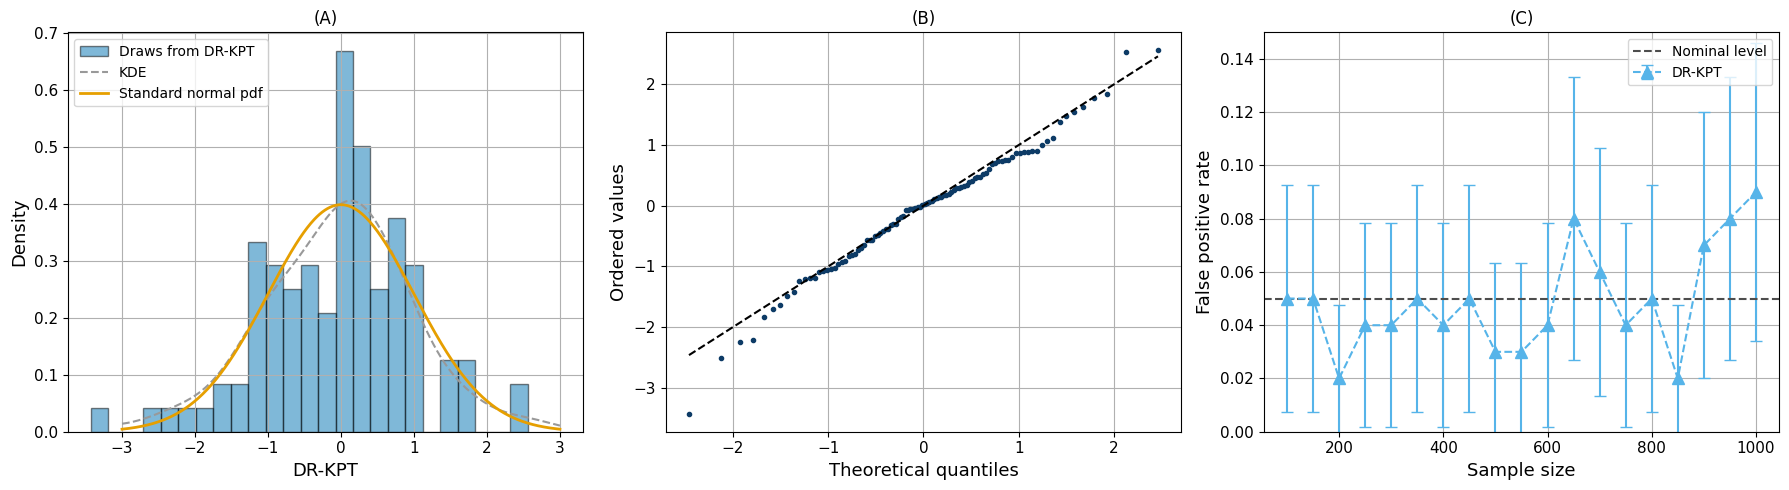

In [9]:
plot_null_diagnostics_observational(
    d_results,
    scenario="I",
    method="DR-CF",
    ns=400,
    name_folder="results/",
    ns_list=np.arange(100, 1050, 50),
    confidence_level=0.05,
    save_path="plots/null_scenarioI_errorbar.png"
)


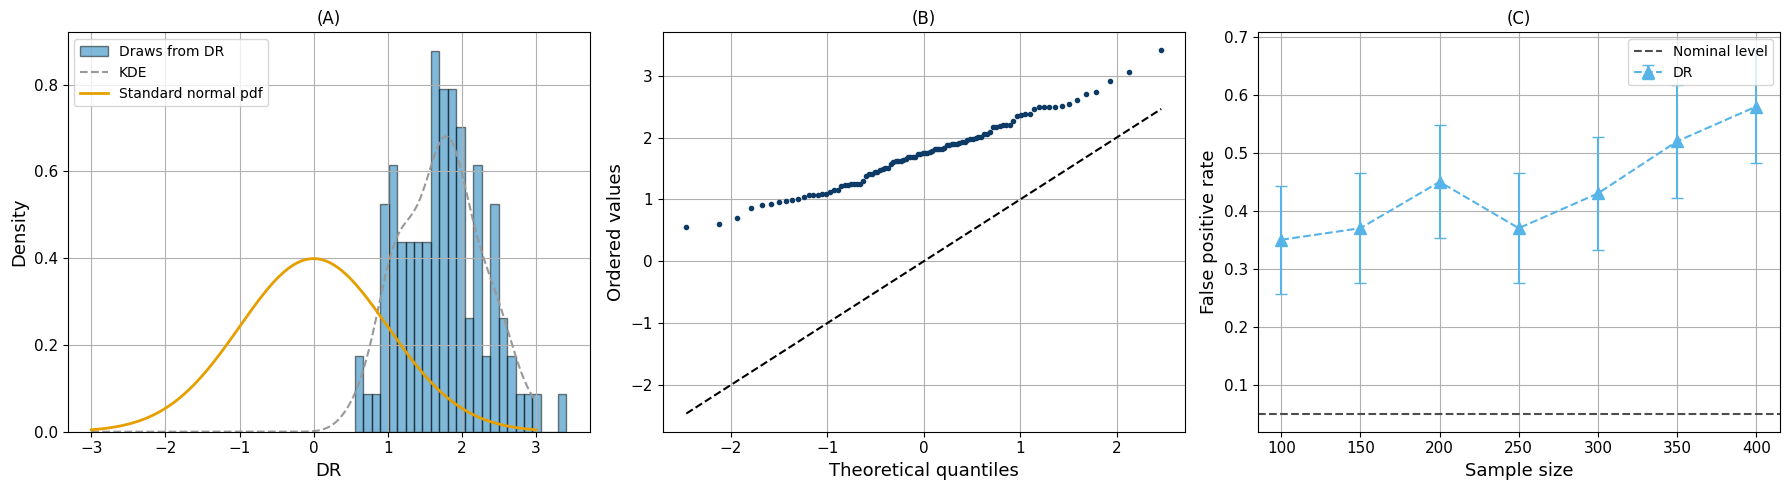

In [15]:
plot_null_diagnostics_observational(
    d_results,
    scenario="I",
    method="DR",
    ns=400,
    name_folder="results/",
    ns_list=sample_size_list,
    confidence_level=0.05,
    save_path="plots/null_dr_nonCF_scenarioI_errorbar.png",
)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_power_scenarios_observational(
    d,
    scenario_list=["II", "III", "IV"],
    ns_list=[100, 150, 200, 250, 300, 350],
    methods=["PE-linear", "KPE", "DR-CF"],
    name_folder="results/",
    confidence_level=0.05,
    save_path="plots/scenarios234_errorbar.png",
    treatments='continuous'
):
    # === Styling ===
    plt.rcParams["figure.figsize"] = (16, 4)
    plt.rc("legend", fontsize=12)
    plt.rc("axes", labelsize=15)
    plt.rc("xtick", labelsize=15)
    plt.rc("ytick", labelsize=15)
    plt.rcParams["axes.grid"] = True

    fig, axs = plt.subplots(1, 3, constrained_layout=True)

    # === Mappings ===
    method_dict = {"DR": "DR", "KPE": "KPT", "DR-CF": "DR-KPT", "PE-linear": "PT-linear"}
    colors = {
        "PE-linear": "#E69F00",
        "KPE": "#0072B2",
        "DR-CF": "#009E73",
        "DR": "#56B4E9"
    }
    m_dict = {0: "^", 1: "s", 2: "v", 3: "o", 4: "D"}
    scenario_titles = {"II": "(II)", "III": "(III)", "IV": "(IV)"}
    ns_array = np.array(ns_list)

    for col, scenario in enumerate(scenario_list):
        ax = axs[col]
        ax.set_title(scenario_titles[scenario])
        ax.set_ylim((-0.05, 1.05))
        ax.set_xlabel("Sample size")
        ax.set_xticks(ns_list)
        ax.grid(True, linestyle="--", alpha=0.6)
        if col == 0:
            ax.set_ylabel("True positive rate")

        for i, method in enumerate(methods):
            rejection_proportion = []
            for ns in ns_list:
                fname = f"{name_folder}ns{ns}_treatments_{treatments}_scenario{scenario}_{method}.csv"
                pvals = d[fname]["p_value"]
                rej = (pvals < confidence_level).mean()
                rejection_proportion.append(rej)
            rejection_proportion = np.array(rejection_proportion)
            varhat = rejection_proportion * (1 - rejection_proportion) / len(pvals)
            ax.errorbar(
                x=ns_array,
                y=rejection_proportion,
                yerr=1.96 * np.sqrt(varhat),
                capsize=4,
                marker=m_dict[i],
                linestyle='--',
                linewidth=1.5,
                markersize=8,
                label=method_dict[method],
                color=colors.get(method, "#333333")
            )
        ax.axhline(confidence_level, color="black", linestyle=":", linewidth=1)
        ax.legend(loc="lower left")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()



In [14]:
plot_power_scenarios_observational(
    d=d_results,  # your loaded results dictionary
    scenario_list=["II", "III", "IV"],
    ns_list=sample_size_list,
    methods=["DR-CF", "KPE", "PE-linear"],
    name_folder="results/",
    confidence_level=0.05,
    save_path="plots/continuous_scenarios234_errorbar.png"
)